# Who's that Pokemon

Goal, to create a model that names Generation 1 Pokemon

There are 151 Pokemon in the first generation, so lots of classes, this won't be an easy problem

The dataset I'm using came from https://www.kaggle.com/datasets/lantian773030/pokemonclassification/data . Less than 7000 pictures and only around 30 for each Pokemon so this is probably not going to get above 50% accuracy. But remember, 151 different types Pokemon

Actually only 149 Pokemon, I think it's the male and female Nidoran that's missing

I deleted a few images that were causing errors as well

## GPU Run
The training on this will take longer than things we've done previously. The outputs on this workbook were done on a laptop that has an Nvidia GPU. A really crap Nvidia GPU with very little RAM (4GB VRAM, worse than a 3050), but a GPU nonetheless

I would not recommend you running everything in this yourself as you may be waiting a while

For comparison, the first training model says 13-15m/s a step, mostly 2 seconds an epoch - on my regular ATU laptop this took 125ms/step and 22s an epoch

And the speeds just take longer from there as the models get more complicated

### Notes
This also won't be a completely comprehensive thing done and maybe I could get a better score, it's demonstrating things including transfer learning

https://www.kaggle.com/datasets/echometerhhwl/pokemon-gen-1-38914 has a 4GB dataset of Pokemon that might work better

I have this included to suppress some tensorflow warnings and errors that were annoying me

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf
import numpy as np

In [3]:
import pandas as pd

In [4]:
print(tf.__version__)

2.16.1


In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Setting Up the Dataset

I'm going to use image_dataset_from_directory to load the images - it is a little restrictive and creating a ImageDataGenerator may be more flexible, especially for data augmentation - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

But I'm doing it this way

Starting with an IMG_SIZE of 128x128

In [6]:
IMG_SIZE = (128, 128)
batch_size=32
train_dir = "PokemonData"

I'm going to have a training dataset and a validation dataset. No test dataset here as I didn't want to

Important parameters, shuffle being true ensures the data is randomised, label_mode='categorical' gives us one-hot encoding labels so we use CategoricalCrossentropy. Leave label_mode to default and you use SparseCategoricalCrossentropy

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            image_size=IMG_SIZE, validation_split=0.2
                                                           , subset='training', label_mode='categorical', 
                                                           seed=1138, batch_size=batch_size)

Found 6773 files belonging to 149 classes.
Using 5419 files for training.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            image_size=IMG_SIZE, validation_split=0.2
                                                           , subset='validation',label_mode='categorical',
                                                           seed=1138, batch_size=batch_size)

Found 6773 files belonging to 149 classes.
Using 1354 files for validation.


In [9]:
num_classes = len(train_dataset.class_names)

In [10]:
class_names = train_dataset.class_names
class_names

['Abra',
 'Aerodactyl',
 'Alakazam',
 'Arbok',
 'Arcanine',
 'Articuno',
 'Beedrill',
 'Bellsprout',
 'Blastoise',
 'Bulbasaur',
 'Butterfree',
 'Caterpie',
 'Chansey',
 'Charizard',
 'Charmander',
 'Charmeleon',
 'Clefable',
 'Clefairy',
 'Cloyster',
 'Cubone',
 'Dewgong',
 'Diglett',
 'Ditto',
 'Dodrio',
 'Doduo',
 'Dragonair',
 'Dragonite',
 'Dratini',
 'Drowzee',
 'Dugtrio',
 'Eevee',
 'Ekans',
 'Electabuzz',
 'Electrode',
 'Exeggcute',
 'Exeggutor',
 'Farfetchd',
 'Fearow',
 'Flareon',
 'Gastly',
 'Gengar',
 'Geodude',
 'Gloom',
 'Golbat',
 'Goldeen',
 'Golduck',
 'Golem',
 'Graveler',
 'Grimer',
 'Growlithe',
 'Gyarados',
 'Haunter',
 'Hitmonchan',
 'Hitmonlee',
 'Horsea',
 'Hypno',
 'Ivysaur',
 'Jigglypuff',
 'Jolteon',
 'Jynx',
 'Kabuto',
 'Kabutops',
 'Kadabra',
 'Kakuna',
 'Kangaskhan',
 'Kingler',
 'Koffing',
 'Krabby',
 'Lapras',
 'Lickitung',
 'Machamp',
 'Machoke',
 'Machop',
 'Magikarp',
 'Magmar',
 'Magnemite',
 'Magneton',
 'Mankey',
 'Marowak',
 'Meowth',
 'Metapod',


This could make loading files more efficient, but no real need for when less than 7000 files

You need to make sure you have saved the class_names before using a cache

In [44]:
AUTOTUNE = tf.data.AUTOTUNE

"""train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)"""

'train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)\nvalidation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)'

In [45]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 149), dtype=tf.float32, name=None))>

In [14]:
from tensorflow.keras import layers

In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1],3)))
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 149)            │        19,221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218,741 (16.09 MB)

 Trainable params: 4,218,741 (16.09 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [15]:
model.fit(train_dataset,  validation_data=(validation_dataset), epochs=100, callbacks=[callback])

Epoch 1/100


I0000 00:00:1713804428.696116   56961 service.cc:145] XLA service 0x7f53c8009800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713804428.696269   56961 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A1000 Laptop GPU, Compute Capability 8.6


  9/170 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0104 - loss: 5.9427

I0000 00:00:1713804432.520000   56961 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.0113 - loss: 5.1434 - val_accuracy: 0.0318 - val_loss: 4.6924
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0834 - loss: 4.2733 - val_accuracy: 0.1950 - val_loss: 3.5394
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3709 - loss: 2.6309 - val_accuracy: 0.2873 - val_loss: 3.1742
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6158 - loss: 1.5014 - val_accuracy: 0.3257 - val_loss: 3.1506
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7949 - loss: 0.7660 - val_accuracy: 0.3375 - val_loss: 3.4509
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9104 - loss: 0.3501 - val_accuracy: 0.3191 - val_loss: 3.9998
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9643 - loss: 0.1631 - val_accuracy: 0.3205 - val_loss: 4.2291
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9734 - loss: 0.1389 - val_accurac

Best val_loss is the 6th last one, 3.1506. This has training accuracy of 61.58% and val accuracy of 32.57%. We can get better training accuracy obviously (the last one is 98%!), but this is clearly overfit.

Let's first try some data augmentation and build it into the model

In [64]:
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

In [17]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1],3)))
model.add(data_augmentation_layers)
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
model.fit(train_dataset,  validation_data=(validation_dataset), epochs=100, callbacks=[callback])

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.0191 - loss: 4.9682 - val_accuracy: 0.1189 - val_loss: 3.9695
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1550 - loss: 3.6127 - val_accuracy: 0.2651 - val_loss: 3.0279
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2870 - loss: 2.8871 - val_accuracy: 0.3035 - val_loss: 2.8579
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3855 - loss: 2.4128 - val_accuracy: 0.3656 - val_loss: 2.5230
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4482 - loss: 2.1110 - val_accuracy: 0.4291 - val_loss: 2.3559
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5106 - loss: 1.8449 - val_accuracy: 0.4261 - val_loss: 2.3181
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5500 - loss: 1.6739 - val_accuracy: 0.4535 - val_loss: 2.2601
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5937 - loss: 1.4631 - 

Best val_loss is 2.1327 with a validation accuracy of 49.19%, this is a good improvement but still some overfitting (62.94% on training set). More epochs would probably make the overfitting worse looking at above

Let's try dropout

In [23]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1],3)))
model.add(data_augmentation_layers)
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [26]:
model.fit(train_dataset,  validation_data=(validation_dataset), epochs=100, callbacks=[callback])

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.0153 - loss: 5.0127 - val_accuracy: 0.0502 - val_loss: 4.6068
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.0759 - loss: 4.2716 - val_accuracy: 0.1595 - val_loss: 3.5927
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.1724 - loss: 3.4314 - val_accuracy: 0.2238 - val_loss: 3.1942
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2356 - loss: 2.9988 - val_accuracy: 0.2578 - val_loss: 2.9845
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2999 - loss: 2.7487 - val_accuracy: 0.3087 - val_loss: 2.7823
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3210 - loss: 2.5614 - val_accuracy: 0.3427 - val_loss: 2.6513
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3819 - loss: 2.3915 - val_accuracy: 0.3567 - val_loss: 2.5689
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3913 - loss: 2.2895 - 

Actually no better with droppout 9ms/step - accuracy: 0.5971 - loss: 1.4699 - val_accuracy: 0.4660 - val_loss: 2.1565 is the best line. Which was worse than without droppout. I would probably try increasing the patience here as clearly the training score can improve and maybe that'd kick the val score up too.

Anyway, we're really at a limit of what we can do with such a small dataset - Transfer Learning might improve things

## Transfer Learning
Like the tutorial, we are going to use Xception as our base model, initialised as below

In [60]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1],3),
    include_top=False)

In [61]:
base_model.trainable = False

Setting things up like in the notes

In [62]:
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1],3))

I'm going to include data_augmentation in this one as it made such a difference with the custom CNN it'll probably make a difference here too

If you want to compare with and without, well you'll have to do it yourself!

In [30]:
x = data_augmentation_layers(inputs)

In [31]:
x = tf.keras.applications.xception.preprocess_input(x)

In [32]:
x = base_model(x, training=False)

In [33]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [34]:
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

In [35]:
model = tf.keras.Model(inputs, outputs)

In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Timing
on my ATU laptop this took 900 ms per step and over 150s per epoch

Much much faster on this laptop which has a crappy GPU. I would try this on my desktop PC except I don't want to install WSL and all the Python stuff on that

In [37]:
model.fit(train_dataset,  validation_data=(validation_dataset), epochs=100, callbacks=[callback])

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.1356 - loss: 4.4275 - val_accuracy: 0.4084 - val_loss: 2.7256
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.5445 - loss: 2.0899 - val_accuracy: 0.4631 - val_loss: 2.3206
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.6622 - loss: 1.5624 - val_accuracy: 0.5037 - val_loss: 2.1102
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.7160 - loss: 1.3060 - val_accuracy: 0.5229 - val_loss: 2.0056
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.7649 - loss: 1.0983 - val_accuracy: 0.5591 - val_loss: 1.9028
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.7927 - loss: 0.9599 - val_accuracy: 0.5665 - val_loss: 1.8488
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.8313 - loss: 0.8062 - val_accuracy: 0.5613 - val_loss: 1.8096
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.8366 - los

Performance is better alright! Took longer to train though, 85-90m/s per step on this computer (Much longer on ATU Laptop!!)

0.9257 - loss: 0.3919 - val_accuracy: 0.6012 - val_loss: 1.7291

Val_loss has decreased. Val accuracy upto 60%. Not too bad for so many categories I think. Still overfitting so let's try to improve it, we'll add a dropout layer.

However, I doubt it'll improve things, Dropout did not work much on the previous CNN and I already have included data_augmentation

### Note
base_model does not need to be reinitialised - unless we do any fine-tuning, it is only rewritten again below as I restarted the kernel

In [15]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1],3),
    include_top=False)
base_model.trainable = False
x = data_augmentation_layers(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes)(x)
model = tf.keras.Model(inputs, outputs)

For some reason I decided not to have softmax on the last layer here (the reason is to make students notice the difference!)

So I have to set from_logits as True

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 149)            │       305,301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,166,781 (80.74 MB)

 Trainable params: 305,301 (1.16 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [19]:
model.fit(train_dataset,  validation_data=(validation_dataset), epochs=100, callbacks=[callback])

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.1220 - loss: 4.5135 - val_accuracy: 0.3900 - val_loss: 2.7408
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.5130 - loss: 2.2256 - val_accuracy: 0.4668 - val_loss: 2.3291
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.6215 - loss: 1.7032 - val_accuracy: 0.4985 - val_loss: 2.1208
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.6824 - loss: 1.4335 - val_accuracy: 0.5111 - val_loss: 2.0121
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.7208 - loss: 1.2304 - val_accuracy: 0.5458 - val_loss: 1.9484
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.7504 - loss: 1.0921 - val_accuracy: 0.5591 - val_loss: 1.8996
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.7769 - loss: 0.9847 - val_accuracy: 0.5613 - val_loss: 1.8615
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.7886 - loss: 0

accuracy: 0.8734 - loss: 0.5400 - val_accuracy: 0.5968 - val_loss: 1.7445

Dropout didn't help. Oh well

Now let's try more Dense layers, again I don't think it'll do much but worth a try

In [65]:
x = data_augmentation_layers(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes)(x)
model = tf.keras.Model(inputs, outputs)

In [66]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_9 (TrueDivide)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_9 (Subtract)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 149)            │       152,725 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,161,981 (92.17 MB)

 Trainable params: 3,300,501 (12.59 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [67]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
model.fit(train_dataset,  validation_data=(validation_dataset), epochs=100, callbacks=[callback])

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.0845 - loss: 4.5476 - val_accuracy: 0.3117 - val_loss: 2.9071
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.3812 - loss: 2.5471 - val_accuracy: 0.4077 - val_loss: 2.3484
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.5101 - loss: 1.8980 - val_accuracy: 0.4727 - val_loss: 2.1754
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.5899 - loss: 1.5355 - val_accuracy: 0.4705 - val_loss: 2.1745
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.6406 - loss: 1.2640 - val_accuracy: 0.4852 - val_loss: 2.1772
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.7101 - loss: 1.0751 - val_accuracy: 0.4897 - val_loss: 2.1937
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - accuracy: 0.7343 - loss: 0.9163 - val_accuracy: 0.5096 - val_loss: 2.2129
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.7752 - loss: 

More parameters, longer training time and..... it's performance is not better. I even tried a patience of 8 to give it some more time to turn things around - didn't work

Would a different data augmentation do anything?

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


In [29]:
x = data_augmentation(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes)(x)
model = tf.keras.Model(inputs, outputs)

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_4 (TrueDivide)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_4 (Subtract)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 149)            │       305,301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,166,781 (80.74 MB)

 Trainable params: 305,301 (1.16 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_dataset,  validation_data=(validation_dataset), epochs=100, callbacks=[callback])

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.1156 - loss: 4.5430 - val_accuracy: 0.3242 - val_loss: 2.9996
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.4563 - loss: 2.4432 - val_accuracy: 0.4106 - val_loss: 2.5898
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.5585 - loss: 1.9651 - val_accuracy: 0.4291 - val_loss: 2.3922
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.5996 - loss: 1.7005 - val_accuracy: 0.4579 - val_loss: 2.2728
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.6673 - loss: 1.4694 - val_accuracy: 0.4697 - val_loss: 2.2039
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.6868 - loss: 1.3313 - val_accuracy: 0.4830 - val_loss: 2.1734
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.7198 - loss: 1.2124 - val_accuracy: 0.4904 - val_loss: 2.1251
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.7445 - loss: 1

No, it did not do anything

Let's try different image sizes. I'm going to shrink images to the smallest they can be for Xception

This time we will need to reload the training and validation datasets, using the same seed will give us the same split

### Note
This time also we need to instantiate the base_model as we will be changing one of it's parameters

In [36]:
IMG_SIZE = (71, 71)

In [37]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            image_size=IMG_SIZE, validation_split=0.2
                                                           , subset='training', label_mode='categorical', 
                                                           seed=1138, batch_size=batch_size)
validation_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            image_size=IMG_SIZE, validation_split=0.2
                                                           , subset='validation',label_mode='categorical',
                                                           seed=1138, batch_size=batch_size)

Found 6773 files belonging to 149 classes.
Using 5419 files for training.
Found 6773 files belonging to 149 classes.
Using 1354 files for validation.


We also need to instantiate the data_augmentation_layers as these depend on the input size

Don't forget to redefine inputs too

In [41]:
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1],3))
base_model = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1],3),
    include_top=False)
base_model.trainable = False
x = data_augmentation_layers(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes)(x)
model = tf.keras.Model(inputs, outputs)

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 71, 71, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 71, 71, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_5 (TrueDivide)      │ (None, 71, 71, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_5 (Subtract)           │ (None, 71, 71, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 3, 3, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 149)            │       305,301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,166,781 (80.74 MB)

 Trainable params: 305,301 (1.16 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [43]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_dataset,  validation_data=(validation_dataset), epochs=100, callbacks=[callback])

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.0974 - loss: 4.7322 - val_accuracy: 0.2770 - val_loss: 3.2847
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4144 - loss: 2.5566 - val_accuracy: 0.3456 - val_loss: 2.9493
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5076 - loss: 2.1128 - val_accuracy: 0.3693 - val_loss: 2.8052
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5650 - loss: 1.8178 - val_accuracy: 0.3914 - val_loss: 2.6974
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6292 - loss: 1.6007 - val_accuracy: 0.4010 - val_loss: 2.6313
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6520 - loss: 1.4489 - val_accuracy: 0.4254 - val_loss: 2.6230
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6985 - loss: 1.3151 - val_accuracy: 0.4239 - val_loss: 2.5868
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7221 - loss: 1.1859 -

It's worse with smaller images

Maybe bigger images = better?

In [11]:
IMG_SIZE = (299, 299)

In [12]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            image_size=IMG_SIZE, validation_split=0.2
                                                           , subset='training', label_mode='categorical', 
                                                           seed=1138, batch_size=batch_size)
validation_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            image_size=IMG_SIZE, validation_split=0.2
                                                           , subset='validation',label_mode='categorical',
                                                           seed=1138, batch_size=batch_size)

Found 6773 files belonging to 149 classes.
Using 5419 files for training.
Found 6773 files belonging to 149 classes.
Using 1354 files for validation.


Redoing the model, including inputs, basemodel and data augmentation

In [15]:
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1],3))
base_model = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1],3),
    include_top=False)
base_model.trainable = False
x = data_augmentation_layers(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes)(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 149)            │       305,301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,166,781 (80.74 MB)

 Trainable params: 305,301 (1.16 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_dataset,  validation_data=(validation_dataset), epochs=100, callbacks=[callback])

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 87s 450ms/step - accuracy: 0.1028 - loss: 4.6638 - val_accuracy: 0.4025 - val_loss: 3.2872
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 75s 440ms/step - accuracy: 0.5591 - loss: 2.7299 - val_accuracy: 0.5052 - val_loss: 2.5278
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 72s 420ms/step - accuracy: 0.6901 - loss: 1.9333 - val_accuracy: 0.5665 - val_loss: 2.1377
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 71s 419ms/step - accuracy: 0.7596 - loss: 1.4925 - val_accuracy: 0.5997 - val_loss: 1.9083
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 72s 422ms/step - accuracy: 0.8062 - loss: 1.2207 - val_accuracy: 0.6204 - val_loss: 1.7674
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 72s 421ms/step - accuracy: 0.8388 - loss: 1.0339 - val_accuracy: 0.6374 - val_loss: 1.6642
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 72s 421ms/step - accuracy: 0.8717 - loss: 0.8836 - val_accuracy: 0.6374 - val_loss: 1.6010
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 72s 422ms/step - accuracy: 0.8873 -

That's the best we've got so far 

accuracy: 0.9915 - loss: 0.1244 - val_accuracy: 0.6817 - val_loss: 1.2805

but longest length of time to do an epoch, bigger images = more features = more training time

We could add more dense layers, but this time with regularisation and maybe this would do better. Or dropout with more dense layers.

Some fine-tuning of the network may help too, but we're already overfit so I'm not sure

or we just accept 68% accuracy with 149 categories is not that bad for now, especially with how few images we started with

### Using the model

We can load a different directory for test data

In [18]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
          "test",
           shuffle=False,        #or False
           image_size=IMG_SIZE)

Found 3 files belonging to 2 classes.


In [19]:
predictions = model.predict(test_dataset)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[-15.753512 , -20.568079 , -17.409592 , -21.129429 , -15.526989 ,
        -18.235369 , -21.851618 , -16.851467 , -16.969446 , -16.330324 ,
        -23.207123 , -17.067112 , -12.929646 , -15.521098 ,  -9.547735 ,
        -11.47732  , -22.370789 , -12.986443 , -25.137352 , -13.621695 ,
        -18.329826 , -10.947722 , -18.248014 , -16.608208 , -17.906548 ,
        -18.721043 ,  -7.6655207, -14.600732 ,  -6.593982 , -11.859476 ,
         -9.313738 , -16.032318 , -13.420492 , -20.094965 , -17.259537 ,
        -19.799    ,  -8.15565  , -17.552761 ,  -9.665804 , -14.406064 ,
        -13.181795 , -18.478264 , -11.486462 , -17.602884 , -15.401005 ,
        -19.746683 , -15.489764 , -20.1081   , -17.548935 , -12.053834 ,
        -22.212875 , -19.882587 , -13.238405 , -20.470463 , -13.744305 ,
        -10.041298 , -19.436035 , -16.585854 , -10.487458 , -14.539312 ,
        -15.067054 , -17.110956 , -20.334145 , -15.550175 ,  -9.827502 ,
        -14.533242 , -18.98246  , -16.99719  , -20.

Not very readable and we need a softmax to get us probabilites

In [20]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [24]:
probability_model.predict(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0.00004869, 0.00000039, 0.00000929, 0.00000023, 0.00006107,
        0.00000407, 0.00000011, 0.00001624, 0.00001443, 0.00002735,
        0.00000003, 0.00001309, 0.00081998, 0.00006143, 0.02412963,
        0.00350383, 0.00000007, 0.00077471, 0.        , 0.00041044,
        0.0000037 , 0.00595037, 0.00000402, 0.00002071, 0.00000565,
        0.0000025 , 0.1584842 , 0.00015419, 0.46275297, 0.00239097,
        0.03049119, 0.00003684, 0.00050192, 0.00000063, 0.0000108 ,
        0.00000085, 0.09707903, 0.00000805, 0.02144243, 0.00018733,
        0.00063723, 0.00000319, 0.00347194, 0.00000766, 0.00006926,
        0.0000009 , 0.00006338, 0.00000063, 0.00000808, 0.00196864,
        0.00000008, 0.00000078, 0.00060216, 0.00000044, 0.00036308,
        0.01472987, 0.00000122, 0.00002118, 0.00942831, 0.00016396,
        0.00009673, 0.00001253, 0.0000005 , 0.00005967, 0.01824103,
        0.00016496, 0.00000193, 0.00001404, 0.00000057, 0.00006579,
        0.00005723, 0.00000455, 0.01254126, 0.00

Let's use pandas to make this more readable

In [30]:
test_dataset.file_paths

['test/eevee/eevee.jpg',
 'test/pikachu/pikachu1.jpg',
 'test/pikachu/pikachu2.jpg']

In [31]:
predictions = probability_model.predict(test_dataset)
df = pd.DataFrame(predictions, columns=class_names, index=test_dataset.file_paths)
df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,Abra,Aerodactyl,Alakazam,Arbok,Arcanine,Articuno,Beedrill,Bellsprout,Blastoise,Bulbasaur,...,Vileplume,Voltorb,Vulpix,Wartortle,Weedle,Weepinbell,Weezing,Wigglytuff,Zapdos,Zubat
test/eevee/eevee.jpg,0.000049,3.948901e-07,0.000009,2.252606e-07,0.000061,0.000004,1.094063e-07,1.623979e-05,1.443254e-05,0.000027,...,0.000820,0.000010,0.009999,0.005016,0.000188,0.000774,1.173741e-07,0.000446,3.778934e-08,5.406331e-06
test/pikachu/pikachu1.jpg,0.016226,5.829396e-06,0.000069,2.880424e-07,0.002175,0.000030,3.379369e-08,2.009317e-05,8.779124e-07,0.000018,...,0.000022,0.000022,0.260320,0.006336,0.005100,0.005249,6.835066e-06,0.000048,3.818425e-07,8.024666e-06
test/pikachu/pikachu2.jpg,0.003975,1.735465e-07,0.000030,1.674762e-06,0.000205,0.000003,2.355118e-08,5.444100e-07,6.083387e-06,0.000009,...,0.000202,0.000004,0.022150,0.015202,0.002737,0.000948,1.970723e-06,0.000045,1.297913e-08,6.729967e-07


In [34]:
df['Max'] = df.idxmax(axis=1)

In [35]:
df

,Abra,Aerodactyl,Alakazam,Arbok,Arcanine,Articuno,Beedrill,Bellsprout,Blastoise,Bulbasaur,...,Voltorb,Vulpix,Wartortle,Weedle,Weepinbell,Weezing,Wigglytuff,Zapdos,Zubat,Max
test/eevee/eevee.jpg,0.000049,3.948901e-07,0.000009,2.252606e-07,0.000061,0.000004,1.094063e-07,1.623979e-05,1.443254e-05,0.000027,...,0.000010,0.009999,0.005016,0.000188,0.000774,1.173741e-07,0.000446,3.778934e-08,5.406331e-06,Drowzee
test/pikachu/pikachu1.jpg,0.016226,5.829396e-06,0.000069,2.880424e-07,0.002175,0.000030,3.379369e-08,2.009317e-05,8.779124e-07,0.000018,...,0.000022,0.260320,0.006336,0.005100,0.005249,6.835066e-06,0.000048,3.818425e-07,8.024666e-06,Vulpix
test/pikachu/pikachu2.jpg,0.003975,1.735465e-07,0.000030,1.674762e-06,0.000205,0.000003,2.355118e-08,5.444100e-07,6.083387e-06,0.000009,...,0.000004,0.022150,0.015202,0.002737,0.000948,1.970723e-06,0.000045,1.297913e-08,6.729967e-07,Drowzee


Unfortunately it got all those wrong! 

In [38]:
df['Eevee']

test/eevee/eevee.jpg         0.030491
test/pikachu/pikachu1.jpg    0.002575
test/pikachu/pikachu2.jpg    0.017059
Name: Eevee, dtype: float32

Not the result we wanted. Let's look at individual files

I don't want the scientific notation

In [23]:
np.set_printoptions(suppress=True)

In [40]:
from PIL import Image

In [41]:
import numpy as np

In [42]:
pikachu_image = np.array(Image.open("pikachu1.jpg").resize((IMG_SIZE[0],IMG_SIZE[1])))

In [43]:
pikachu_image = pikachu_image.reshape(1,IMG_SIZE[0],IMG_SIZE[1],3)

In [46]:
ans = probability_model.predict(pikachu_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


In [50]:
pd.DataFrame(ans, columns=class_names).idxmax(axis=1)

0    Vulpix
dtype: object

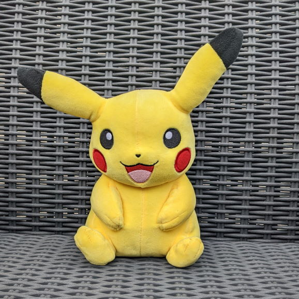

In [51]:
Image.open("pikachu2.jpg").resize((IMG_SIZE[0],IMG_SIZE[1]))

In [52]:
pikachu_image = np.array(Image.open("pikachu2.jpg").resize((IMG_SIZE[0],IMG_SIZE[1])))
pikachu_image = pikachu_image.reshape(1,IMG_SIZE[0],IMG_SIZE[1],3)

In [53]:
ans = probability_model.predict(pikachu_image)
pd.DataFrame(ans, columns=class_names).idxmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


0    Drowzee
dtype: object

In [55]:
eevee_image = np.array(Image.open("eevee.jpg").resize((IMG_SIZE[0],IMG_SIZE[1])))
eevee_image = eevee_image.reshape(1,IMG_SIZE[0],IMG_SIZE[1],3)

In [56]:
ans = probability_model.predict(eevee_image)
pd.DataFrame(ans, columns=class_names).idxmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


0    Dragonite
dtype: object

In [57]:
mimikyu_image = np.array(Image.open("mimikyu.jpg").resize((IMG_SIZE[0],IMG_SIZE[1])))
mimikyu_image = mimikyu_image.reshape(1,IMG_SIZE[0],IMG_SIZE[1],3)

In [60]:
ans = probability_model.predict(mimikyu_image)
pd.DataFrame(ans, columns=class_names).idxmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


0    Drowzee
dtype: object

In [61]:
bulba_image = np.array(Image.open("bulbasaur.jpg").resize((IMG_SIZE[0],IMG_SIZE[1])))
bulba_image = bulba_image.reshape(1,IMG_SIZE[0],IMG_SIZE[1],3)

In [62]:
ans = probability_model.predict(bulba_image)
pd.DataFrame(ans, columns=class_names).idxmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


0    Bulbasaur
dtype: object

## It got one of them right!! 

In [66]:
import glob as glob

In [67]:
filelist = glob.glob("evalimages/*.jpg")

In [68]:
filelist

['evalimages/charmander.jpg',
 'evalimages/vulpix.jpg',
 'evalimages/mimikyu.jpg',
 'evalimages/mew.jpg',
 'evalimages/eevee.jpg',
 'evalimages/bulbasaur.jpg',
 'evalimages/charizard.jpg',
 'evalimages/pikachu2.jpg',
 'evalimages/pikachu1.jpg',
 'evalimages/jigglypuff.jpg']

In [69]:
test_images = np.array([np.array(Image.open(fname).resize((IMG_SIZE[0],IMG_SIZE[1]))) for fname in filelist])

In [73]:
ans = probability_model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


In [75]:
df = pd.DataFrame(ans, columns=class_names, index=filelist)

In [76]:
df['Max'] = df.idxmax(axis=1)

In [77]:
df['Max']

evalimages/charmander.jpg    Kangaskhan
evalimages/vulpix.jpg            Machop
evalimages/mimikyu.jpg          Pikachu
evalimages/mew.jpg            Dragonite
evalimages/eevee.jpg          Dragonite
evalimages/bulbasaur.jpg      Bulbasaur
evalimages/charizard.jpg        Drowzee
evalimages/pikachu2.jpg         Drowzee
evalimages/pikachu1.jpg          Vulpix
evalimages/jigglypuff.jpg    Jigglypuff
Name: Max, dtype: object

It got Bulbasaur and Jigglypuff right. Not a brilliant result, guess it doesn't like those toys - maybe the background messed things up anyway. You should see a lot of options that could be implemented

It also predicted Mimikyu to be Pikachu. Mimikyu will be so happy with that result

In [79]:
import matplotlib.pyplot as plt

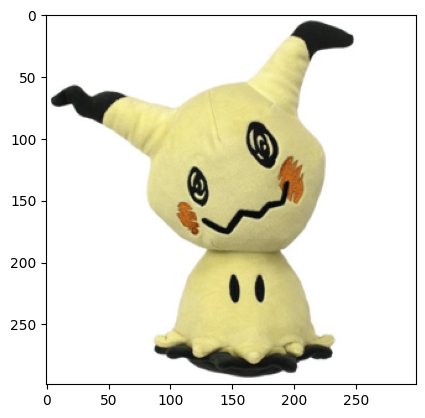

In [80]:
plt.imshow(test_images[2])
plt.show()